In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import ipaddress
from pandas.tools.plotting import scatter_matrix
from sklearn import preprocessing
from functools import reduce

In [2]:
%%time

raw_path = os.path.join('/media/thiago/ubuntu/datasets/network/','stratosphere-botnet-2011/ctu-13/raw/')
pkl_path = os.path.join('/media/thiago/ubuntu/datasets/network/','stratosphere-botnet-2011/ctu-13/pkl/')

raw_directory = os.fsencode(raw_path)
pkl_directory = os.fsencode(pkl_path)

raw_files = os.listdir(raw_directory)
sample_file = raw_files[6]

pkl_file_path = os.path.join(pkl_directory, sample_file).decode('utf-8')
raw_file_path = os.path.join(raw_directory, sample_file).decode('utf-8')

print("Directory: ", raw_directory)
print("Files: ", raw_files)

# read pickle or raw dataset file with pandas
clean = False
if os.path.isfile(pkl_file_path):
    df = pd.read_pickle(pkl_file_path)
    clean = True
    print("Sample File: ", pkl_file_path)
else:
    df = pd.read_csv(raw_file_path, low_memory=False, dtype={'Label':'str'})
    print("Sample File: ", raw_file_path)

Directory:  b'/media/thiago/ubuntu/datasets/network/stratosphere-botnet-2011/ctu-13/raw/'
Files:  [b'capture20110810.binetflow', b'capture20110811.binetflow', b'capture20110812.binetflow', b'capture20110815-2.binetflow', b'capture20110815-3.binetflow', b'capture20110815.binetflow', b'capture20110816-2.binetflow', b'capture20110816-3.binetflow', b'capture20110816.binetflow', b'capture20110817.binetflow', b'capture20110818-2.binetflow', b'capture20110818.binetflow', b'capture20110819.binetflow']
Sample File:  /media/thiago/ubuntu/datasets/network/stratosphere-botnet-2011/ctu-13/pkl/capture20110816-2.binetflow
CPU times: user 21.6 ms, sys: 561 µs, total: 22.1 ms
Wall time: 21.1 ms


In [3]:
print("\nData Shape: ", df.shape)
print("\nData Types: ", df.dtypes)
df.head()
# data overview
# print("\nProto:\n", df['Proto'].value_counts())
# print("\nSrcAddr:\n", df['SrcAddr'].value_counts())
# print("\nDstAddr:\n", df['DstAddr'].value_counts())
# print("\nDport:\n", df['Dport'].value_counts())
# print("\nState:\n", df['State'].value_counts())
# print("\nsTos:\n", df['sTos'].value_counts())
# print("\ndTos:\n", df['dTos'].value_counts())
# print("\nLabel:\n", df['Label'].value_counts())


Data Shape:  (114077, 14)

Data Types:  Dur         float64
Proto         int64
SrcAddr      object
Sport         int64
Dir           int64
DstAddr      object
Dport         int64
State         int64
sTos          int64
dTos          int64
TotPkts       int64
TotBytes      int64
SrcBytes      int64
Label         int64
dtype: object


,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
StartTime,,,,,,,,,,,,,,
2011-08-16 13:52:03,2.925519,9,147.32.86.58,3184,0,77.75.73.9,80,120,0,0,3,182,122,0
2011-08-16 13:52:17,1.046300,9,147.32.3.51,4420,0,147.32.84.46,10010,123,0,0,4,244,124,0
2011-08-16 13:52:32,2.898050,9,147.32.86.58,3246,0,77.75.73.9,80,120,0,0,3,182,122,0
2011-08-16 13:58:28,8.979935,9,212.95.7.124,8811,0,147.32.84.229,13363,108,0,0,7,508,208,0
2011-08-16 13:58:55,5.832105,9,109.166.138.80,58325,0,147.32.84.229,13363,108,0,0,8,538,294,0


In [4]:
%%time
# feature engineering
if not clean:
    print('Data Cleasing and Feature Engineering')
    le = preprocessing.LabelEncoder()

    # [Protocol] - Discard ipv6-icmp and categorize
    # df = df[df.Proto != 'ipv6-icmp']
    df['Proto'] = df['Proto'].fillna('-')
    df['Proto'] = le.fit_transform(df['Proto'])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

    # [Label] - Categorize 
    anomalies = df.Label.str.contains("Botnet")
    normal = np.invert(anomalies);
    df.loc[anomalies, 'Label'] = int(1)
    df.loc[normal, 'Label'] = int(0)
    df['Label'] = pd.to_numeric(df['Label'])

    # [Dport] - replace NaN with 0 port number
    df['Dport'] = df['Dport'].fillna('0')
    df['Dport'] = df['Dport'].apply(lambda x: int(x,0))

    # [sport] - replace NaN with 0 port number
    df['Sport'] = df['Sport'].fillna('0')
    df['Sport'] = df['Sport'].apply(lambda x: int(x,0))

    # [sTos] - replace NaN with "10" and convert to int
    df['sTos'] = df['sTos'].fillna('10')
    df['sTos'] = df['sTos'].astype(int)

    # [dTos] - replace NaN with "10" and convert to int
    df['dTos'] = df['dTos'].fillna('10')
    df['dTos'] = df['dTos'].astype(int)

    # [State] - replace NaN with "-" and categorize
    df['State'] = df['State'].fillna('-')
    df['State'] = le.fit_transform(df['State'])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

    # [Dir] - replace NaN with "-" and categorize 
    df['Dir'] = df['Dir'].fillna('-')
    df['Dir'] = le.fit_transform(df['Dir'])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

    # [SrcAddr] Extract subnet features and categorize
    df['SrcAddr'] = df['SrcAddr'].fillna('0.0.0.0')
    # tmp_df = pd.DataFrame(df['SrcAddr'].str.split('.').tolist(), columns = ['1','2','3','4'])
    # df["SrcAddr1"] = tmp_df["1"]
    # df["SrcAddr2"] = tmp_df["1"].map(str) + tmp_df["2"]
    # df["SrcAddr3"] = tmp_df["1"].map(str) + tmp_df["2"].map(str) + tmp_df["3"]
    # df['SrcAddr0'] = le.fit_transform(df['SrcAddr'])
    # le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    # df['SrcAddr1'] = df['SrcAddr1'].astype(int)
    # df['SrcAddr2'] = df['SrcAddr2'].astype(int)
    # df['SrcAddr3'] = df['SrcAddr3'].astype(int)

    # [DstAddr] Extract subnet features
    df['DstAddr'] = df['DstAddr'].fillna('0.0.0.0')
    # tmp_df = pd.DataFrame(df['DstAddr'].str.split('.').tolist(), columns = ['1','2','3','4'])
    # df["DstAddr1"] = tmp_df["1"]
    # df["DstAddr2"] = tmp_df["1"].map(str) + tmp_df["2"]
    # df["DstAddr3"] = tmp_df["1"].map(str) + tmp_df["2"].map(str) + tmp_df["3"]
    # df['DstAddr0'] = le.fit_transform(df['DstAddr'])
    # df['DstAddr1'] = df['DstAddr1'].astype(int)
    # df['DstAddr2'] = df['DstAddr2'].astype(int)
    # df['DstAddr3'] = df['DstAddr3'].astype(int)

    # [StartTime] - Parse to datatime, reindex based on StartTime, but first drop the ns off the time stamps
    df['StartTime'] = df['StartTime'].apply(lambda x: x[:19])
    df['StartTime'] = pd.to_datetime(df['StartTime'])
    df = df.set_index('StartTime')
    
    # save clean data into pickles
    df.to_pickle(pkl_file_path)  # where to save it, usually as a .pkl
else:
    print('Clean Data Loaded:')
    print(pkl_file_path)

Clean Data Loaded:
/media/thiago/ubuntu/datasets/network/stratosphere-botnet-2011/ctu-13/pkl/capture20110816-2.binetflow
CPU times: user 164 µs, sys: 54 µs, total: 218 µs
Wall time: 159 µs


In [5]:
print("\nData Shape: ", df.shape)
print("\nData Types: ", df.dtypes)
df.head()


Data Shape:  (114077, 14)

Data Types:  Dur         float64
Proto         int64
SrcAddr      object
Sport         int64
Dir           int64
DstAddr      object
Dport         int64
State         int64
sTos          int64
dTos          int64
TotPkts       int64
TotBytes      int64
SrcBytes      int64
Label         int64
dtype: object


,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
StartTime,,,,,,,,,,,,,,
2011-08-16 13:52:03,2.925519,9,147.32.86.58,3184,0,77.75.73.9,80,120,0,0,3,182,122,0
2011-08-16 13:52:17,1.046300,9,147.32.3.51,4420,0,147.32.84.46,10010,123,0,0,4,244,124,0
2011-08-16 13:52:32,2.898050,9,147.32.86.58,3246,0,77.75.73.9,80,120,0,0,3,182,122,0
2011-08-16 13:58:28,8.979935,9,212.95.7.124,8811,0,147.32.84.229,13363,108,0,0,7,508,208,0
2011-08-16 13:58:55,5.832105,9,109.166.138.80,58325,0,147.32.84.229,13363,108,0,0,8,538,294,0


In [6]:
# %%time
# v_features = [
#     'Dur',
#     'Proto',
#     'Dir',
#     'Dport',
#     'State',
#     'TotPkts',
#     'TotBytes',
#     'SrcBytes'
# #     ,
# #     'SrcAddr0',
# #     'DstAddr0',
# #     'DstAddr1',
# #     'DstAddr2',
# #     'DstAddr3'
# ]

# nplots=np.size(v_features)
# plt.figure(figsize=(15,4*nplots))
# gs = gridspec.GridSpec(nplots,1)
# for i, cn in enumerate(df[v_features]):
#     ax = plt.subplot(gs[i])
# #     print(cn)
#     sns.distplot(df[cn][df.Label == 1], bins=10, label='anomaly', color='r')
#     sns.distplot(df[cn][df.Label == 0], bins=10, label='normal', color='b')
#     ax.set_xlabel('')
#     ax.set_title('feature: ' + str(cn))
#     plt.legend()
# plt.savefig('distplot_df.png')
# plt.show()

CPU times: user 1.56 s, sys: 534 ms, total: 2.09 s
Wall time: 1.53 s


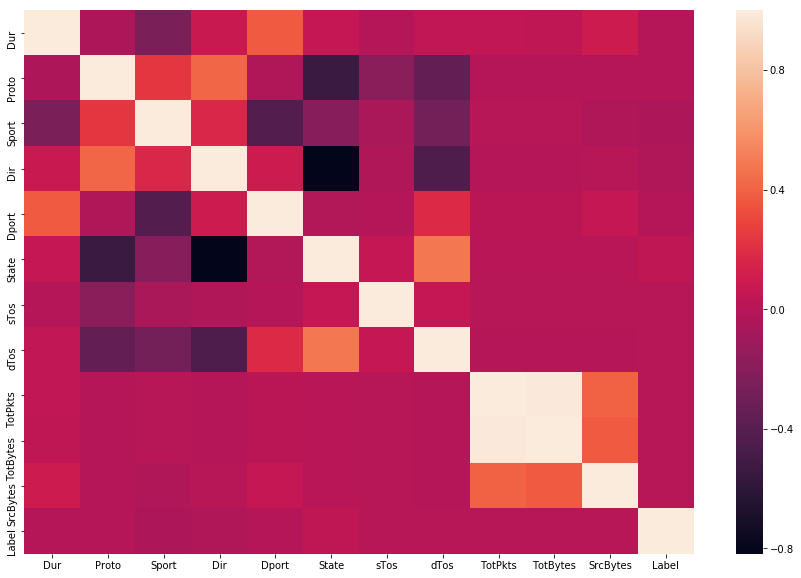

In [7]:
%%time
corr = df.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns_plot = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, ax=ax)
figure = sns_plot.get_figure()
figure.savefig('figures/corr_df.png', dpi=400)

In [8]:
# %%time
# # drops N/A values
# tmp_df = df.dropna()

# # Create a scatter matrix of the aggregated dataframe
# # choose a few interesting features to pairplot based on the heat maps
# plot_features = ['Dur','Proto','Dir','Dport','State','sTos','dTos','TotPkts','Label']
# sns_plot = sns.pairplot(tmp_df, vars=plot_features, hue='Label')
# sns_plot.savefig("pairplot_df.png")

In [9]:
def classify_ip(ip):
    '''
    str ip - ip address string to attempt to classify. treat ipv6 addresses as N/A
    '''
    try: 
        ip_addr = ipaddress.ip_address(ip)
        if isinstance(ip_addr, ipaddress.IPv6Address):
            return 'ipv6'
        elif isinstance(ip_addr, ipaddress.IPv4Address):
            # split on .
            octs = ip_addr.exploded.split('.')
            if 0 < int(octs[0]) < 127: return 'A'
            elif 127 < int(octs[0]) < 192: return 'B'
            elif 191 < int(octs[0]) < 224: return 'C'
            else: return 'N/A'
    except ValueError:
        return 'N/A'
    
def avg_duration(x):
    return np.average(x)
    
def n_dports_gt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a,b: a+b if b>1024 else a),x)
n_dports_gt1024.__name__ = 'n_dports>1024'

def n_dports_lt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a,b: a+b if b<1024 else a),x)
n_dports_lt1024.__name__ = 'n_dports<1024'

def n_sports_gt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a,b: a+b if b>1024 else a),x)
n_sports_gt1024.__name__ = 'n_sports>1024'

def n_sports_lt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a,b: a+b if b<1024 else a),x)
n_sports_lt1024.__name__ = 'n_sports<1024'

def label_atk_v_norm(x):
    for l in x:
        if l == 1: return 1
    return 0
label_atk_v_norm.__name__ = 'label'

def background_flow_count(x):
    count = 0
    for l in x:
        if l == 0: count += 1
    return count

def normal_flow_count(x):
    if x.size == 0: return 0
    count = 0
    for l in x:
        if l == 0: count += 1
    return count

def n_conn(x):
    return x.size

def n_tcp(x):
    count = 0
    for p in x: 
        if p == 10: count += 1 # tcp == 10
    return count
    
def n_udp(x):
    count = 0
    for p in x: 
        if p == 11: count += 1 # udp == 11
    return count
    
def n_icmp(x):
    count = 0
    for p in x: 
        if p == 1: count += 1 # icmp == 1
    return count

def n_s_a_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'A': count += 1
    return count
    
def n_d_a_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'A': count += 1
    return count

def n_s_b_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'B': count += 1
    return count

def n_d_b_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'A': count += 1
    return count
        
def n_s_c_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'C': count += 1
    return count
    
def n_d_c_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'C': count += 1
    return count
        
def n_s_na_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'N/A': count += 1
    return count
    
def n_d_na_p_address(x):
    count = 0
    for i in x: 
        if classify_ip(i) == 'N/A': count += 1
    return count

def n_ipv6(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'ipv6': count += 1
    return count

In [10]:
# # The datastructure to hold our feature extraction functions, 
# # which will get applied to each aggregation of the datasets.
# extractors = {
#     'Label'   : [label_atk_v_norm, background_flow_count, normal_flow_count, n_conn,],
#     'Dport'   : [n_dports_gt1024, n_dports_lt1024],
#     'Sport'   : [n_sports_gt1024, n_sports_lt1024,],
#     'Dur'     : [avg_duration,],
#     'SrcAddr' : [n_s_a_p_address, n_s_b_p_address, n_s_c_p_address, n_s_na_p_address,],
#     'DstAddr' : [n_d_a_p_address, n_d_b_p_address, n_d_c_p_address, n_d_na_p_address,],
#     'Proto'   : [n_tcp, n_icmp, n_udp,],
# }
    
# # resample grouped by 1 second bin. must have a datetime-like index.
# r = df.resample('1S')
# n_df = r.agg(extractors) ## aggretation by data and functions specified by extractors

# n_df.columns = n_df.columns.droplevel(0) # get rid of the heirarchical columns
# pd.options.display.max_columns = 99

In [11]:
# print('New nData Types: ', n_df.dtypes)
# n_df.head()

In [12]:
# %%time
# n_features = ['background_flow_count','normal_flow_count','n_conn','n_dports>1024','n_dports<1024','n_s_a_p_address','n_s_b_p_address','n_s_c_p_address','n_s_na_p_address','n_d_a_p_address','n_d_b_p_address','n_d_c_p_address']
# plt.figure(figsize=(15,4*nplots))
# gs = gridspec.GridSpec(nplots,1)
# for i, cn in enumerate(n_df[n_features]):
#     ax = plt.subplot(gs[i])
# #     print(cn)
#     sns.distplot(n_df[cn][n_df.label == 1], bins=10, label='anomaly', color='r')
#     sns.distplot(n_df[cn][n_df.label == 0], bins=10, label='normal', color='b')
#     ax.set_xlabel('')
#     ax.set_title('feature: ' + str(cn))
#     plt.legend()
# plt.show()

In [13]:
# %%time
# corr = n_df.corr()
# fig, ax = plt.subplots(figsize=(15,10))
# sns_plot = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, ax=ax)
# figure = sns_plot.get_figure()
# figure.savefig('corr_df.png', dpi=400)

In [14]:
# %%time
# # drops N/A values
# tmp_df = n_df.dropna()

# # Create a scatter matrix of the aggregated dataframe
# # choose a few interesting features to pairplot based on the heat maps
# plot_features = ['avg_duration','n_udp','background_flow_count','n_conn','n_icmp']
# sns.pairplot(tmp_df, vars=plot_features, hue='label')

In [15]:
import random as rnd
import plotly.graph_objs as go
import lime
import lime.lime_tabular
from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import classification_report, average_precision_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma, allow_singular=True)
    return p.pdf(dataset)

def selectThresholdByCV(probs, labels):
    
    # select best epsilon (threshold)
    best_epsilon = 0
    best_f1 = 0
    best_precision = 0
    best_recall = 0
    f = 0
    farray = []
    Recallarray = []
    Precisionarray = []
    epsilons = (1.0527717316e-70,
                1.0527717316e-50,
                1.0527717316e-35,
                1.0527717316e-30,
                1.0527717316e-26,
                1.0527717316e-24,
                3.5558382249e-20,
                1.0527717316e-20,
                7.7136390000e-15,
                7.5136390000e-12,
                1.0527717316e-10,                
                0.0000e+00)
    #epsilons = np.asarray(epsilons)

    anom_df = pd.DataFrame(probs[labels==1])    
    print(anom_df[0].value_counts())
    
    probs_df = pd.DataFrame(data=probs[labels==1])
    labels.plot(style='k.')
    probs_df.plot(style='k.')
    plt.show()

    for epsilon in epsilons:
        predictions = (probs < epsilon)
        
        f = f1_score(labels, predictions, average = "binary")
        Recall = recall_score(labels, predictions, average = "binary")
        Precision = precision_score(labels, predictions, average = "binary")
        
        farray.append(f)
        Recallarray.append(Recall)
        Precisionarray.append(Precision)
        print('For below Epsilon')
        print(epsilon)
        print('F1 score, Recall and Precision:')
        print('Best F1 Score %f' %f)
        print('Best Recall Score %f' %Recall)
        print('Best Precision Score %f' %Precision)
        print('-'*40)
        if f > best_f1:
            best_epsilon = epsilon
            best_f1 = f
            best_precision = Precision
            best_recall = Recall
                       
            
    # plot results
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.5, 0.7, 0.3])
    #plt.subplot(3,1,1)
    plt.plot(farray ,"ro")
    plt.plot(farray)
    ax.set_xticks(range(12))
    ax.set_xticklabels(epsilons,rotation = 60 ,fontsize = 'medium' )
    ax.set_ylim((0,1.1))
    ax.set_title('F1 score vs Epsilon value')
    ax.annotate('Best F1 Score', xy=(best_epsilon,best_f1), xytext=(best_epsilon,best_f1))
    plt.xlabel("Epsilon value") 
    plt.ylabel("F1 Score") 
    plt.show()
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.5, 0.9, 0.3])
    #plt.subplot(3,1,2)
    plt.plot(Recallarray ,"ro")
    plt.plot(Recallarray)
    ax.set_xticks(range(12))
    ax.set_xticklabels(epsilons,rotation = 60 ,fontsize = 'medium' )
    ax.set_ylim((0,1.1))
    ax.set_title('Recall vs Epsilon value')
    ax.annotate('Best Recall Score', xy=(best_epsilon, best_recall), xytext=(best_epsilon, best_recall))
    plt.xlabel("Epsilon value") 
    plt.ylabel("Recall Score") 
    plt.show()
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.5, 0.9, 0.3])
    #plt.subplot(3,1,3)
    plt.plot(Precisionarray ,"ro")
    plt.plot(Precisionarray)
    ax.set_xticks(range(12))
    ax.set_xticklabels(epsilons,rotation = 60 ,fontsize = 'medium' )
    ax.set_ylim((0,1.1))
    ax.set_title('Precision vs Epsilon value')
    ax.annotate('Best Precision Score', xy=(best_epsilon,best_precision), xytext=(best_epsilon,best_precision))
    plt.xlabel("Epsilon value") 
    plt.ylabel("Precision Score") 
    plt.show()
    return best_f1, best_epsilon

def print_classification_report(y_test, y_predic):
    print('Classification report:')
    print(classification_report(y_test, y_predic))

    print('Average Precision = ' + str(average_precision_score(y_test, y_predic)))

    print('\nBinary F1 Score, Recall and Precision:')
    f = f1_score(y_test, y_predic, average = "binary")
    Recall = recall_score(y_test, y_predic, average = "binary")
    Precision = precision_score(y_test, y_predic, average = "binary")
    print('F1 Score %f' %f)
    print('Recall Score %f' %Recall)
    print('Precision Score %f' %Precision)

#     print('\nMicro F1 Score, Recall and Precision:')
#     f = f1_score(y_test, y_predic, average = "micro")
#     Recall = recall_score(y_test, y_predic, average = "micro")
#     Precision = precision_score(y_test, y_predic, average = "micro")
#     print('F1 Score %f' %f)
#     print('Recall Score %f' %Recall)
#     print('Precision Score %f' %Precision)

#     print('\nMacro F1 Score, Recall and Precision:')
#     f = f1_score(y_test, y_predic, average = "macro")
#     Recall = recall_score(y_test, y_predic, average = "macro")
#     Precision = precision_score(y_test, y_predic, average = "macro")
#     print('F1 Score %f' %f)
#     print('Recall Score %f' %Recall)
#     print('Precision Score %f' %Precision)

In [16]:
# drop non discriminant features
df.drop([
#     'Dur',
    'Proto',
    'SrcAddr',
    'Sport',
#     'Dir',
    'DstAddr',
#     'Dport',
#     'State',
    'sTos',
    'dTos',
    'TotPkts',
    'TotBytes',
    'SrcBytes'
], axis =1, inplace = True)
print("train_df_shape: ", df.shape)
print('Train Data Types: ', df.dtypes)
df.head()

train_df_shape:  (114077, 5)
Train Data Types:  Dur      float64
Dir        int64
Dport      int64
State      int64
Label      int64
dtype: object


,Dur,Dir,Dport,State,Label
StartTime,,,,,
2011-08-16 13:52:03,2.925519,0,80,120,0
2011-08-16 13:52:17,1.046300,0,10010,123,0
2011-08-16 13:52:32,2.898050,0,80,120,0
2011-08-16 13:58:28,8.979935,0,13363,108,0
2011-08-16 13:58:55,5.832105,0,13363,108,0


In [17]:
df_l1 = df[df["Label"] == 1]
df_l0 = df[df["Label"] == 0]

print("df_l1_shape: ", df_l1.shape)
print("df_l0_shape: ", df_l0.shape)

df_l1_shape:  (63, 5)
df_l0_shape:  (114014, 5)


In [18]:
# Data splitting

# Length and indexes
norm_len = len(df_l0)
anom_len = len(df_l1)
anom_train_end = anom_len // 2
anom_cv_start = anom_train_end + 1
norm_train_end = (norm_len * 60) // 100
norm_cv_start = norm_train_end + 1
norm_cv_end = (norm_len * 80) // 100
norm_test_start = norm_cv_end + 1

# anomalies split data
anom_cv_df  = df_l1[:anom_train_end] # 50% of anomalies59452 
anom_test_df = df_l1[anom_cv_start:anom_len] # 50% of anomalies

# normal split data
norm_train_df = df_l0[:norm_train_end] # 60% of normal
norm_cv_df = df_l0[norm_cv_start:norm_cv_end] # 2059452 % of normal
norm_test_df = df_l0 [norm_test_start:norm_len] # 20% of normal

# CV and test data. train data is norm_train_df
cv_df = pd.concat([norm_cv_df, anom_cv_df], axis=0)
test_df = pd.concat([norm_test_df, anom_test_df], axis=0)

# labels
cv_label = cv_df["Label"]
test_label = test_df["Label"]

# drop label
norm_train_df.drop(labels = ["Label"], axis = 1, inplace = True)
cv_df.drop(labels = ["Label"], axis = 1, inplace = True)
test_df.drop(labels = ["Label"], axis = 1, inplace = True)

print("norm_train_df_shape: ", norm_train_df.shape)
print("cv_shape: ", cv_df.shape)
print("test_df_shape: ", test_df.shape)

norm_train_df_shape:  (68408, 4)
cv_shape:  (22833, 4)
test_df_shape:  (22833, 4)


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [19]:
%%time
mu, sigma = estimateGaussian(norm_train_df)

CPU times: user 6.99 ms, sys: 5.19 ms, total: 12.2 ms
Wall time: 10.6 ms


In [20]:
%%time
p = multivariateGaussian(norm_train_df, mu, sigma)

CPU times: user 5.69 ms, sys: 0 ns, total: 5.69 ms
Wall time: 6.01 ms


In [21]:
%%time
p_cv = multivariateGaussian(cv_df, mu, sigma)

CPU times: user 7.18 ms, sys: 0 ns, total: 7.18 ms
Wall time: 6.61 ms


In [22]:
%%time
p_test = multivariateGaussian(test_df, mu, sigma)

CPU times: user 1.68 ms, sys: 0 ns, total: 1.68 ms
Wall time: 3.43 ms


1.344355e-11    1
7.878106e-13    1
7.713605e-12    1
7.878075e-13    1
1.534774e-10    1
2.320562e-11    1
7.878052e-13    1
1.534775e-10    1
1.534321e-10    1
7.933773e-13    1
2.541023e-13    1
7.820266e-13    1
1.534321e-10    1
1.534321e-10    1
7.894574e-13    1
1.534321e-10    1
6.791269e-13    1
7.837380e-13    1
3.970493e-11    1
2.307536e-11    1
8.338124e-12    1
8.337799e-12    1
2.326216e-11    1
1.534331e-10    1
1.534321e-10    1
8.254324e-12    1
1.534332e-10    1
1.534321e-10    1
7.721881e-13    1
1.534321e-10    1
1.534321e-10    1
Name: 0, dtype: int64


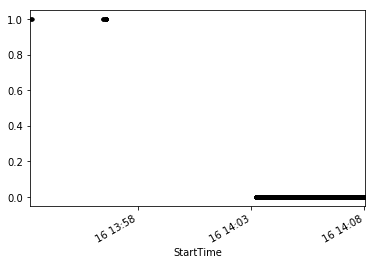

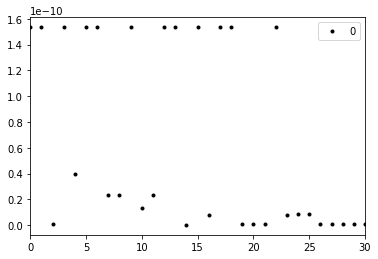

/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.



For below Epsilon
1.0527717316e-70
F1 score, Recall and Precision:
Best F1 Score 0.000000
Best Recall Score 0.000000
Best Precision Score 0.000000
----------------------------------------
For below Epsilon
1.0527717316e-50
F1 score, Recall and Precision:
Best F1 Score 0.000000
Best Recall Score 0.000000
Best Precision Score 0.000000
----------------------------------------
For below Epsilon
1.0527717316e-35
F1 score, Recall and Precision:
Best F1 Score 0.000000
Best Recall Score 0.000000
Best Precision Score 0.000000
----------------------------------------
For below Epsilon
1.0527717316e-30
F1 score, Recall and Precision:
Best F1 Score 0.000000
Best Recall Score 0.000000
Best Precision Score 0.000000
----------------------------------------
For below Epsilon
1.0527717316e-26
F1 score, Recall and Precision:
Best F1 Score 0.000000
Best Recall Score 0.000000
Best Precision Score 0.000000
----------------------------------------
For below Epsilon
1.0527717316e-24
F1 score, Recall and Prec

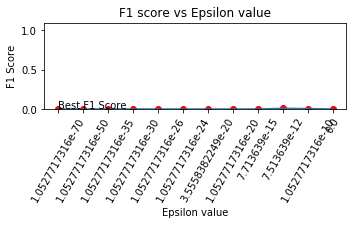

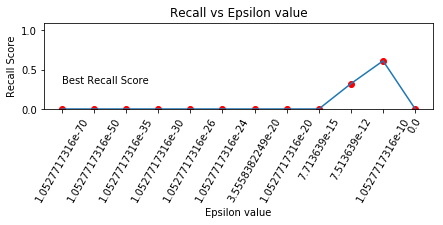

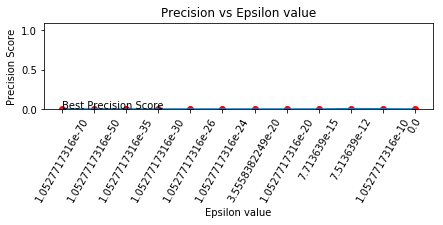

0.008375209380234507 7.513639e-12


In [23]:
fscore, epsilon = selectThresholdByCV(p_cv, cv_label)
print(fscore, epsilon)

In [24]:
print ('Printing classification report for Cross Validation dataset')
pred_label = (p_cv < epsilon)
print_classification_report(cv_label, pred_label)

Printing classification report for Cross Validation dataset
Classification report:
             precision    recall  f1-score   support

          0       1.00      0.90      0.95     22802
          1       0.00      0.32      0.01        31

avg / total       1.00      0.90      0.94     22833

Average Precision = 0.002288328350829213

Binary F1 Score, Recall and Precision:
F1 Score 0.008375
Recall Score 0.322581
Precision Score 0.004243


In [25]:
print ('Printing classification report for for Test dataset')
pred_label = (p_test < epsilon)
print_classification_report(test_label, pred_label)

Printing classification report for for Test dataset
Classification report:
             precision    recall  f1-score   support

          0       1.00      0.89      0.94     22802
          1       0.01      0.55      0.01        31

avg / total       1.00      0.89      0.94     22833

Average Precision = 0.0042719312498924475

Binary F1 Score, Recall and Precision:
F1 Score 0.013183
Recall Score 0.548387
Precision Score 0.006672
